<a href="https://colab.research.google.com/github/ykato27/LSTM/blob/main/RNN_Tutorials_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
 
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

####天気データセット
このチュートリアルは Max-Planck-Institute for Biogeochemistry (生物地球化学) により記録された 天気時系列データセット を使用します。

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
 
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
 
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

データの最初の 300,000 行は訓練データセットで、残りの検証データセットがあります。これは訓練データの ~2100 日分になります。

In [ ]:
TRAIN_SPLIT = 300000

In [ ]:
#seedの固定
tf.random.set_seed(13)

##パート 1 : 単変量時系列を予報する

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5462ee8f60>],
      dtype=object)

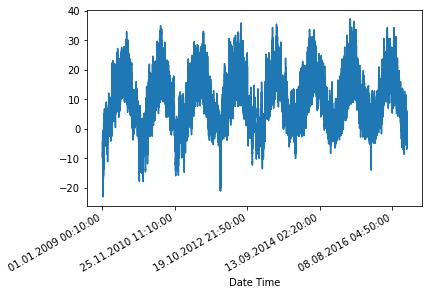

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

データの正規化

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

単変量モデルのためのデータを作成
パート 1 については、モデルは最後の 20 の記録された気温観測が与えられて、そして次の時間ステップでの気温を予測することを学習する必要があります。

In [ ]:
univariate_past_history = 20
univariate_future_target = 0
 
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [ ]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0
 
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

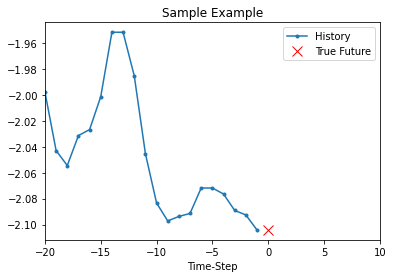

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

####ベースライン
モデルを訓練することに進む前に、最初に単純なベースラインを設定しましょう。入力ポイントが与えられたとき、baseline メソッドは総ての履歴を見てそして次のポイントを最後の 20 観測の平均として予測します。

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

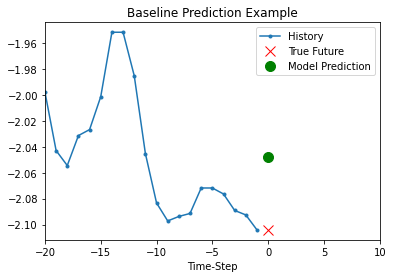

In [ ]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

##LSTM

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
 
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
 
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
 
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
 
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 0.5855 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1559 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0505 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0510 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0271 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0289 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0312 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0280 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0256 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0239 - val_lo

##単純な LSTM モデルを使用して予測

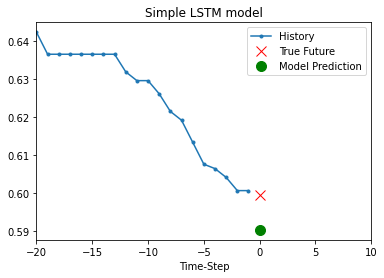

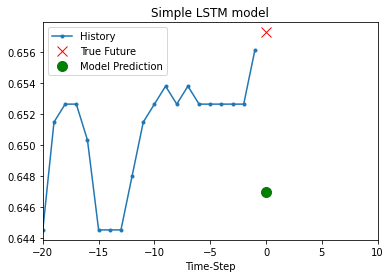

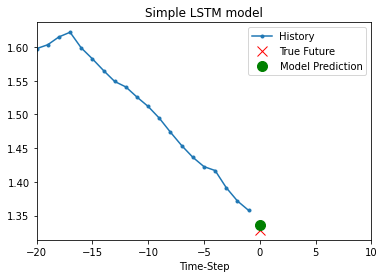

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

##多変量時系列を予報する
元のデータセットは 14 の特徴を含みます。単純化のために、このセクションは元の 14 の 3 つだけを考えます。使用される特徴は気温 (= air temperature)、気圧 (= atmospheric pressure) と空気密度 (= air density) です。

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f545f841828>,
      dtype=object)

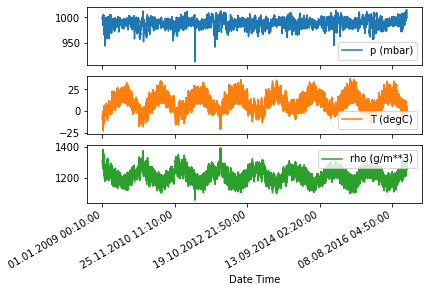

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

##シングルステップ・モデル
シングルステップ・セットアップでは、モデルは提供される幾つかの履歴をもとに未来の単一ポイントを予測することを学習します。

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
 
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
 
  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
 
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
 
  return np.array(data), np.array(labels)

このチュートリアルでは、ネットワークは最後の 5 日間からデータを見せられます、i.e. 毎時サンプリングされる 720 観測です。サンプリングは 1 時間毎に行なわれます、何故ならば 60 分内に極端な変更は想定されないためです。こうして、120 観測が最後の 5 日間の履歴を表します。シングルステップ予測モデルについては、データポイントのためのラベルは未来に向けた気温 12 時間です。このためのラベルを作成するため、72(12*6) 観測後の気温が使用されます。

In [ ]:
past_history = 720
future_target = 72
STEP = 6
 
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
 
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

サンプルの予測

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 22s 100ms/step - loss: 0.3622 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2684 - val_loss: 0.2421
Epoch 3/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2656 - val_loss: 0.2448
Epoch 4/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2630 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 21s 103ms/step - loss: 0.2202 - val_loss: 0.2368
Epoch 6/10
200/200 [==============================] - 21s 103ms/step - loss: 0.2454 - val_loss: 0.2658
Epoch 7/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2428 - val_loss: 0.2565
Epoch 8/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2426 - val_loss: 0.2381
Epoch 9/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2488 - val_loss: 0.2480
Epoch 10/10
200/200 [==============================] - 21s 107ms/step - los

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
 
  epochs = range(len(loss))
 
  plt.figure()
 
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
 
  plt.show()

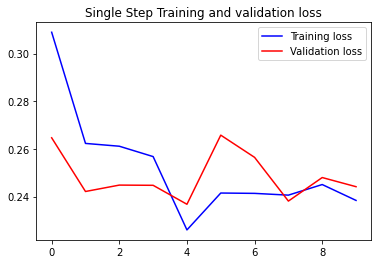

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

シングルステップ未来を予測する

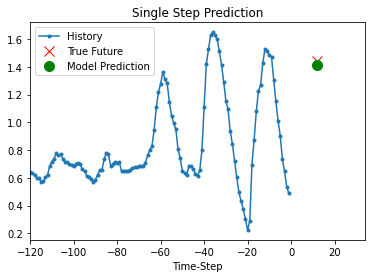

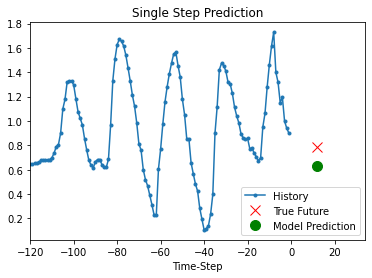

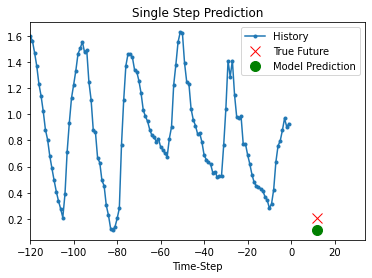

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

##マルチステップ・モデル
マルチステップ予測モデルでは、過去の履歴が与えられたとき、モデルは未来の値の範囲を予測することを学習する必要があります。こうして、単一の特徴ポイントだけが予測されるシングルステップ・モデルと違い、マルチステップ・モデルは未来のシークエンスを予測します。

マルチステップ・モデルについて、訓練データは再度毎時サンプリングされた過去 5 日間に渡る記録から成ります。けれども、ここでは、モデルは次の 12 時間について気温を予測することを学習する必要があります。観測は 10 分毎に取られますので、出力は 72 予測です。このタスクのために、データセットはそれに応じて準備される必要がありますので、最初のステップはそれを単に再度作成することですが、異なるターゲット・ウィンドウでです。

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
# サンプルデータポイントの確認
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
 
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
# サンプルデータポイントをプロット
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
 
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

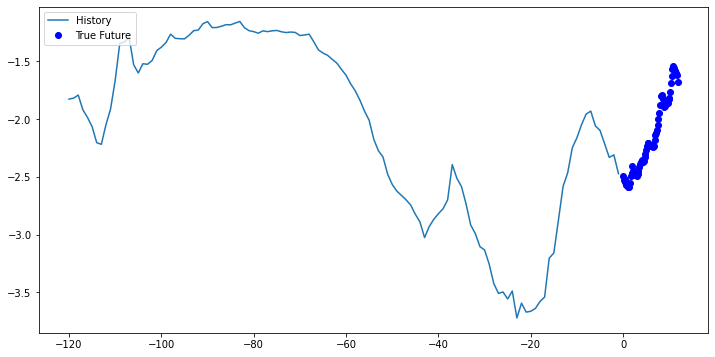

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

ここでのタスクは前のタスクよりも少しだけ複雑ですので、今はモデルは 2 つの LSTM 層から成ります。最後に、72 予測が行なわれますので、dense 層は 72 予測を出力します。



In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))
 
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 38s 177ms/step - loss: 322.9363 - val_loss: 0.2968
Epoch 2/10
200/200 [==============================] - 36s 182ms/step - loss: 0.3447 - val_loss: 0.2778
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.3333 - val_loss: 0.2383
Epoch 4/10
200/200 [==============================] - 36s 183ms/step - loss: 0.2429 - val_loss: 0.2159
Epoch 5/10
200/200 [==============================] - 36s 181ms/step - loss: 0.1912 - val_loss: 0.2020
Epoch 6/10
200/200 [==============================] - 36s 180ms/step - loss: 0.2064 - val_loss: 0.2096
Epoch 7/10
200/200 [==============================] - 39s 193ms/step - loss: 0.2031 - val_loss: 0.1926
Epoch 8/10
200/200 [==============================] - 39s 194ms/step - loss: 0.1986 - val_loss: 0.2025
Epoch 9/10
200/200 [==============================] - 39s 195ms/step - loss: 0.2036 - val_loss: 0.1887
Epoch 10/10
200/200 [==============================] - 39s 197ms/step -

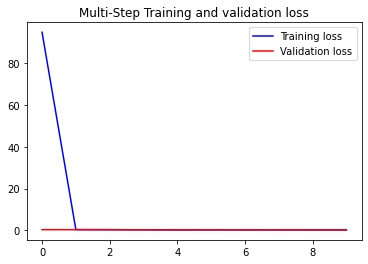

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

####マルチステップ未来を予測する

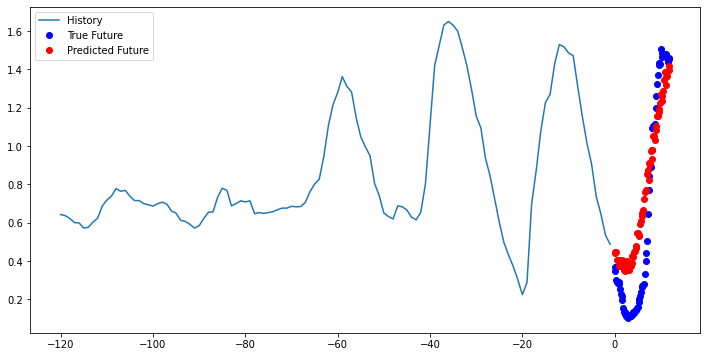

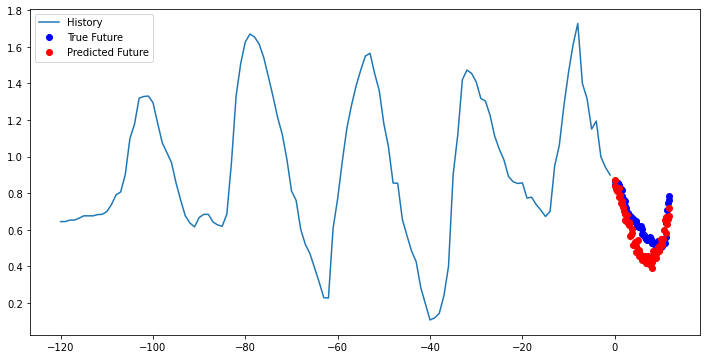

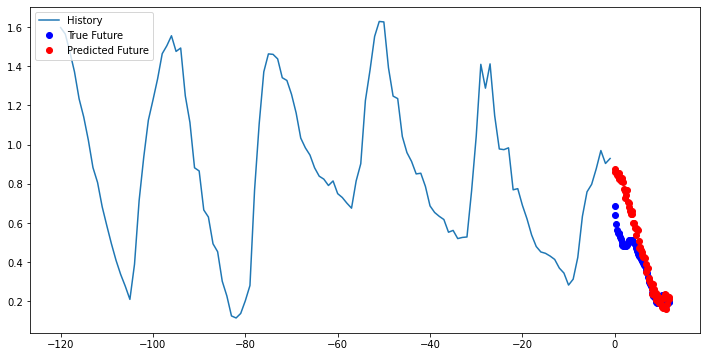

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])